In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from matplotlib.pyplot import figure

from klines import SetOfLines, SetOfPoints, CorsetForKMeansForLines, CoresetForWeightedCenters

In [17]:
## data
k = 3
d = 2
N = int(1e3)
m = int(N*0.07)  # coreset size ~ reduction ratio
tau = 1e-3

In [18]:
straight_roads = np.load('road_segments_china.npy')
straight_roads = straight_roads[np.random.choice(straight_roads.shape[0], N, replace=False)]
L = [[x[0][0], x[0][1], x[1][0], x[1][1]] for x in straight_roads]

In [19]:
## construct set of lines
L = SetOfLines([], [], [], [], L, True)

In [20]:
class ParameterConfig:
    def __init__(self):
        pass

In [21]:
config = ParameterConfig()

config.a_b_approx_minimum_number_of_lines = int(N*0.01) # constant 100, line 2, algo 2 BI-CRITERIA

config.sample_size_for_a_b_approx = int(m*1.01) # |S| >= m, line 3 of algo 2
                                                # note: there'll be a O(|S|^2) cost while computing algo 1
    
config.farthest_to_centers_rate_in_a_b_approx = 4.0/11  # opp of 7/11, line 6, algo 2 BI-CRITERIA
config.number_of_remains_multiply_factor = int(math.log(N))//k # this is `b` in algo 2, other paper, set as random here -  how to calculate it?
config.closest_to_median_rate = (1-tau)/(2*k)  # refer line 4, algo 1, other paper

config.median_sample_size = int(N*0.05)    # size of q_i, line 3, algo 2, other paper
config.max_sensitivity_multiply_factor = 50  # for outliers in coresets


coreset = CorsetForKMeansForLines(config)

## statistical analysis

In [10]:
### RISKY
### FOR MEAN AND VAR EVALUATION
### DONT RUN FOR      *** N > 1,000 ****

ITER = 5
errors = np.array([coreset.coreset(L, k, m)[2]  for _ in range(ITER)])

print(f"mean: {errors.mean()}")
print(f"var: {errors.var()}")

### RISKY 
### don't run on your lap

mean: 6.881897436774193
var: 1.077252561255611


In [ ]:
## more tau => more variance
## more max_sensitivity_multiply_factor => less variance
## kept median_sample_size small, ~5% of N, coz coresets candidate set progressively reduces

mean: 9.61303003972963
var: 0.647864133123555

## graphical analysis

In [22]:
# note size of B will be ~ O(log(n) * m^2)
# and ofcourse its not K-center
S, B, cost = coreset.coreset(L, k, m, True)

print(f"Unweighted coreset size: {B.get_size()}")
print(f"Square distance/Cost: {cost}")

Unweighted coreset size: 33536
Square distance/Cost: 5.353767616058598


In [23]:
config.number_of_remains = int(math.log(B.get_size())) # this is also `b`, line 1, algo 2, other paper
                                                       # value copied from `recursive_robust_median` method
    
cwc = CoresetForWeightedCenters(config)
wB = cwc.coreset(B, k, m)

print(f"Weighted coreset size: {wB.get_size()}")

Weighted coreset size: 70


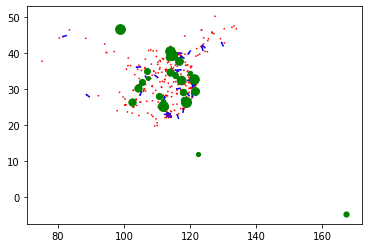

In [9]:
for r in straight_roads:
    plt.plot([r[0][0], r[1][0]], [r[0][1], r[1][1]], 'r')

for i in range(len(S.spans)):
    v1 = S.displacements[i]
    v12 = S.spans[i]
    v2 = v1 - v12
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'b')
        
max_weight = wB.weights[0]  # they are sorted decreasing weight
WT_OUTLIER_THRESHOLD = 0.2  # weights below this threshold ignored in plot

for i in range(int(len(wB.points)*(1-WT_OUTLIER_THRESHOLD))):
    p = wB.points[i]
    plt.plot([p[0]], [p[1]], 'go-', markersize=(wB.weights[i]/max_weight)*10)
    
plt.rcParams['figure.dpi'] = 200 
plt.show()

In [51]:
### RISKY
### FOR TIME EVALUATION
### DONT RUN FOR      *** N > 1,000 ****

import timeit
X = []
ITER = 2
for i in range(ITER):
    st = timeit.default_timer()
    cwc.coreset(B, k, m)
    X.append(timeit.default_timer() - st)
    
X = np.array(X)
print(f"Mean time taken for {ITER} calls is {X.mean()}s")

## RISKY
### DONT RUN ON YOUR LAPTOP

/usr/local/lib/python3.6/dist-packages/klines/set_of_points.py:338: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  P_subset = self_points[distances_smaller_than_median_indices]
/usr/local/lib/python3.6/dist-packages/klines/set_of_points.py:339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  w_subset = self_weights[distances_smaller_than_median_indices]
/usr/local/lib/python3.6/dist-packages/klines/set_of_points.py:340: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

Mean time taken for 2 calls is 6.13816477950013


In [1]:
# import cProfile
# pr = cProfile.Profile()
# pr.enable()

# cwc.coreset(B, k, m)

# pr.disable()
# pr.print_stats(sort='cumtime')